# Analysis on coarse-grained clusters
This notebook produces the figures from the slides of our meeting on November 28. It is fully self-contained, except for requiring the datafile

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import umap
import pickle
from hdbscan import HDBSCAN

color_palette = sns.color_palette('deep', 30)


/Users/thomasr/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
###Fit UMAP
def get_reduction(df):

    reducer = umap.UMAP(min_dist = 0.3, n_neighbors = 25, n_components = 2)
    reducer.fit(df)

    return reducer

In [3]:
def extract_data(df,setup):
    if setup == "all":
        return df
    elif setup == "mixed":
        return df.loc[(slice(None),slice(None),2),:]
    elif setup == "young":
        return df.loc[(slice(None),slice(None),1),:]

In [4]:
###Determine clusters, return updated dataframe with labels of clusters and clusterer
def get_clusters(df,min_cluster_size,cutoff,plot_linkage_tree):
    
    clusterer = HDBSCAN(min_cluster_size=min_cluster_size).fit(df[[0,1]])

    df["label"] = clusterer.labels_
    df["labelx"] = clusterer.single_linkage_tree_.get_clusters(cutoff, min_cluster_size=2)

    n_clusters = len(df.label.unique())
    n_clustersx = len(df.labelx.unique())

    print("Number of clusters = ",n_clusters,"\nNumber of coarse-grained clusters = ",n_clustersx)

    colors = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in df.label]
    colors_p = [sns.desaturate(x, p) for x, p in zip(colors, clusterer.probabilities_)]

    plt.scatter(*df[[0,1]].values.T, s=10,linewidth=0, c=colors_p, alpha=0.5)
    plt.show()
    
    if plot_linkage_tree:
        clusterer.single_linkage_tree_.plot()
        plt.show()

    colorsx = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in df.labelx]
    plt.scatter(*df[[0,1]].values.T, s=10,linewidth=0, c=colorsx, alpha=0.5)
    plt.show()

    return df,clusterer

In [5]:
###Load data
def load_data(folder):
    df = pd.read_csv(folder+'all_individuals_daysbytask.csv')
    df = df.pivot_table(index=['colony','individual','setup type'],columns='behaviour')
    df = df.swaplevel(0,1,axis=1)
    df = df.stack()
    df.index.names = ['Colony','Individual','Setup type','Day']
    df.iloc[np.where(df == 0.5)] = 1
    df.index = df.index.set_levels(df.index.levels[-1].astype(int), level=-1)
    df.sort_index(level=-2,inplace=True)
    return df


## Load data

In [6]:
data = load_data(folder="../../data/") #Load
data = data.sample(len(data),random_state=90) #Randomize
# data = data[~ (data == [0]*13).all(axis=1)] #Remove zeros

## Load or fit UMAP transform

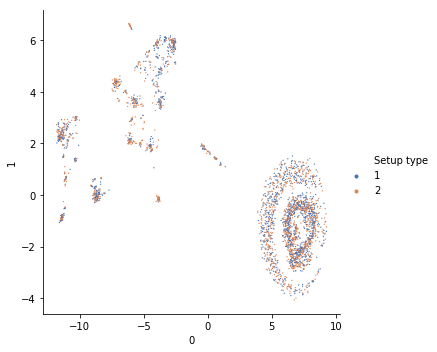

In [7]:
keep_data="all"#all/mixed/young
try:
    reducer = pickle.load(open("../../output/umap-%s.pkl"%keep_data,"rb"))
else:
    df_fit = extract_data(data,keep_data) #Extract specified data
    reducer = get_reduction(df_fit) #Fit
df = pd.DataFrame(reducer.transform(data), index = data.index) #Transform
h = sns.relplot(data=df.reset_index(),x=0,y=1,
            hue="Setup type",hue_order=[1,2],
            style="Setup type",style_order=[1,2],
            markers=[".","."],marker=1,s=1,palette=color_palette[:2]) #Plot


## Determine clusters

Number of clusters =  18 
Number of coarse-grained clusters =  9


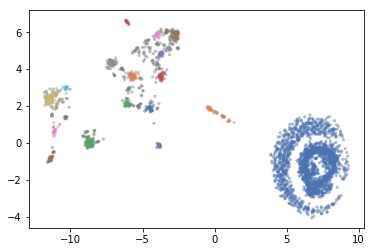

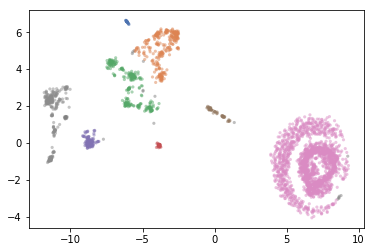

In [8]:
# Two parameters for determining clusters
min_cluster_size=15
cutoff=0.66

#Third parameter (haven't needed to change this yet), by default equal to min_cluster_size
# min_sample_size=15

# Fourth parameter to plot linkage tree (takes a while so set to False for speed)
plot_linkage_tree=False

df,clusterer = get_clusters(df,min_cluster_size,cutoff,plot_linkage_tree=plot_linkage_tree)

# Behavior for fine-grained clusters

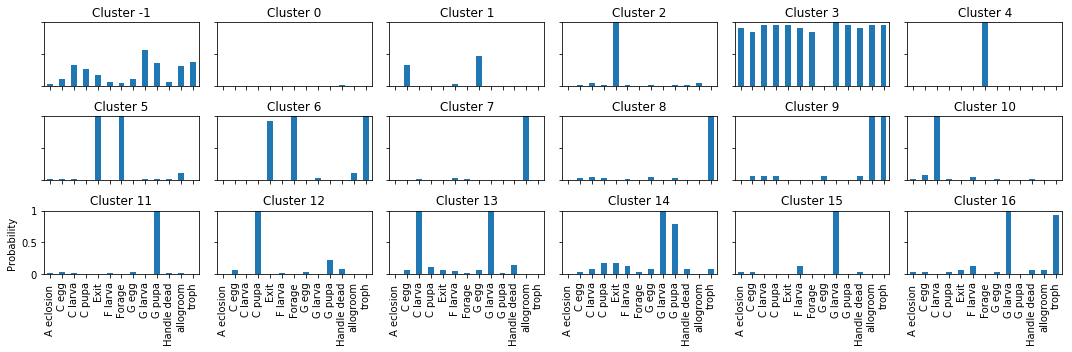

In [9]:
fig,axes=plt.subplots(3,6,figsize=(15,5))
for ax,label in zip(axes.flat,np.arange(-1,df.label.max()+1)):
    data_cluster=data[df.label==label]
    (data_cluster.sum()/len(data_cluster)).plot(ax=ax,kind="bar")

    ax.set(ylim=[0,1],title="Cluster %d"%label,
           yticklabels=[],xlabel="",xticklabels=[])
    if label == 11:
        ax.set(ylabel="Probability",yticks=[0,0.5,1],yticklabels=[0,0.5,1])
    if label >= 11:
        ax.set(xticklabels=data_cluster.columns)
plt.savefig("../../figures/hist/fine-grained-%s-%d-%.2f.pdf"%(keep_data,min_cluster_size,dist),bbox_inches="tight")
plt.tight_layout()
plt.show()

## Behavior for coarse-grained clusters

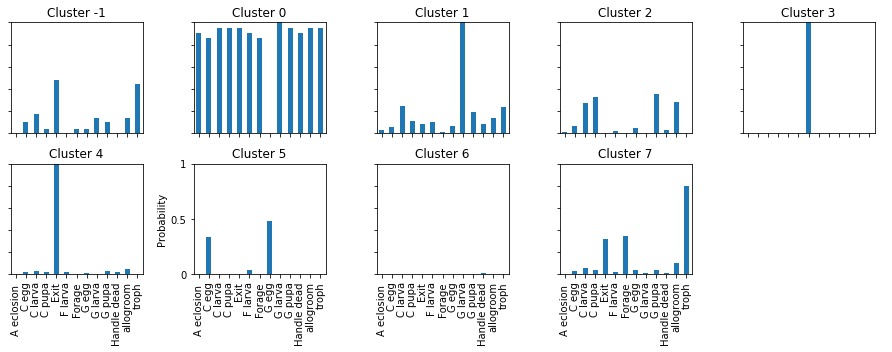

In [10]:
fig,axes=plt.subplots(2,5,figsize=(12.5,5))
for ax,label in zip(axes.flat,np.arange(-1,8)):
    data_cluster=data[df.labelx==label]
    (data_cluster.sum()/len(data_cluster)).plot(ax=ax,kind="bar")

    ax.set(ylim=[0,1],title="Cluster %d"%label,
           yticklabels=[],xlabel="",xticklabels=[])
    if label == 5:
        ax.set(ylabel="Probability",yticks=[0,0.5,1],yticklabels=[0,0.5,1])
    if label >= 4:
        ax.set(xticklabels=data_cluster.columns)
axes[1,4].axis("off")
plt.savefig("../../figures/hist/coarse-grained-%s-%d-%.2f.pdf"%(keep_data,min_cluster_size,dist),bbox_inches="tight")
plt.tight_layout()
plt.show()

## Fine-grained clusters are part of which coarse-grained clusters?

In [11]:
df.groupby(["label","labelx"]).size().sort_index(level="labelx") #size indicates number of datapoints

label  labelx
-1     -1          21
 0     -1           6
 1     -1           1
 2     -1           1
 3      0          21
-1      1         104
 13     1          41
 14     1          23
 15     1          89
 16     1          31
-1      2          43
 7      2          57
 10     2          45
 11     2          56
 12     2          59
 4      3          29
 2      4         118
 1      5          48
 0      6        1833
-1      7          23
 5      7          52
 6      7          28
 8      7         135
 9      7          16
dtype: int64

## Tracking ants in clusters over time

In [12]:
cluster_order = df.set_index("labelx").groupby("labelx").size().sort_values(ascending=False).index
cluster_dict = {k:v for k,v in zip(cluster_order,np.arange(9))}

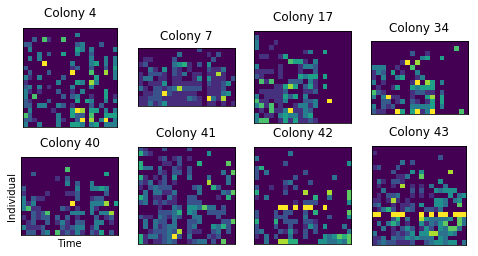

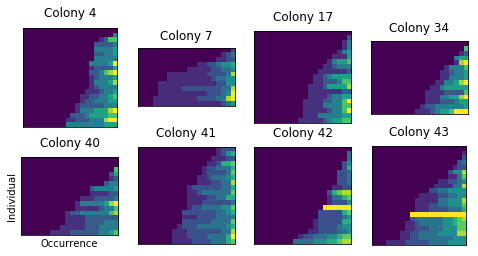

In [13]:
fig1,axes1=plt.subplots(2,4,figsize=(8,4))
fig2,axes2=plt.subplots(2,4,figsize=(8,4))

for ax1,ax2,col in zip(axes1.flat,axes2.flat,[4,7,17,34,40,41,42,43]):

    df_col = df.loc[col]
    n_ants = len(df_col.index.get_level_values("Individual").unique())

    df_col["labelx"] = df_col["labelx"].map(cluster_dict)
    df_col.set_index("labelx",drop=False,append=True,inplace=True)
    
    ind_order = df_col.groupby(level=["Individual","labelx"]).size().sort_values(ascending=False).loc[(slice(None),0)]
    ind_dict = {k:v for k,v in zip(ind_order.index,np.arange(n_ants))}
    df_col["Ind order"] = df_col.index.get_level_values("Individual").map(ind_dict)
    df_col.set_index("Ind order",append=True,inplace=True)

    ax1.matshow(df_col.sort_index(level="Ind order")["labelx"].values.reshape(n_ants,20))
    
    df_col = df_col.swaplevel("Ind order","labelx")
    df_col.sort_index(level=["Ind order","labelx"],inplace=True)
    
    ax2.matshow(df_col["labelx"].values.reshape(n_ants,20))

    if col == 40:
        ax1.set(xlabel="Time",ylabel="Individual")
        ax2.set(xlabel="Occurrence",ylabel="Individual")
    ax1.set(xticks=[],yticks=[],title="Colony %d"%col)
    ax2.set(xticks=[],yticks=[],title="Colony %d"%col)
    
fig1.savefig("../../figures/individuals-over-time.pdf",bbox_inches="tight")
fig2.savefig("../../figures/individuals-frequency.pdf",bbox_inches="tight")

plt.show()

# Distance between individuals in cluster space

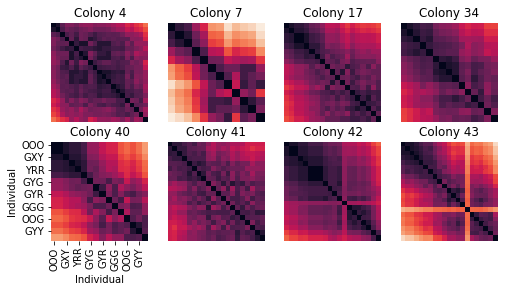

In [14]:
fig,axes=plt.subplots(2,4,figsize=(8,4))
for ax,col in zip(axes.flat,[4,7,17,34,40,41,42,43]):
    df_col=df.loc[col]
    n_ants = len(df_col.index.get_level_values("Individual").unique())
    setup = df_col.index.get_level_values("Setup type").unique()[0]

    df_col["labelx"] = df_col["labelx"].map(cluster_dict)
    df_col.set_index("labelx",append=True,inplace=True)
    
    ind_order = df_col.groupby(level=["Individual","labelx"]).size().sort_values(ascending=False).loc[(slice(None),0)]
    ind_dict = {k:v for k,v in zip(ind_order.index,np.arange(n_ants))}
    df_col["Ind order"] = df_col.index.get_level_values("Individual").map(ind_dict)
    df_col.set_index("Ind order",append=True,inplace=True)

    df_col = df_col.swaplevel("Ind order","labelx")
    df_col.sort_index(level=["Ind order","labelx"],inplace=True)
    
    df_coord = df_col.groupby(level=["Individual","Setup type","labelx","Ind order"]).size()
    df_coord=df_coord.sort_index(level="Ind order").droplevel("Ind order")
    matrix = pd.DataFrame()

    index = pd.MultiIndex.from_arrays([[setup]*9,np.arange(9)],names=["Setup type","labelx"])
    placeholder = pd.DataFrame([0]*9,index=index)

    inds = df_coord.index.get_level_values("Individual").unique()

    for indx in inds:
        a=placeholder.add(df_coord.loc[indx],axis="index").fillna(0)
        dist=[]
        for indy in inds:
            b=placeholder.add(df_coord.loc[indy],axis="index").fillna(0)
            dist.append(np.sqrt(((a-b)**2).sum()[0]))

        matrix[indx] = pd.Series(dist, index=inds)

    sns.heatmap(matrix,ax=ax,vmin=0,vmax=20,cbar=False)
    if col == 40:
        ax.set(xlabel="Individual",ylabel="Individual")
    else:
        ax.axis('off')
    ax.set(title="Colony %d"%col)
plt.savefig("../../figures/distance.pdf",bbox_inches="tight")
plt.show()


## Transitions between clusters

In [15]:
labelx = np.arange(len(df.labelx.unique()))

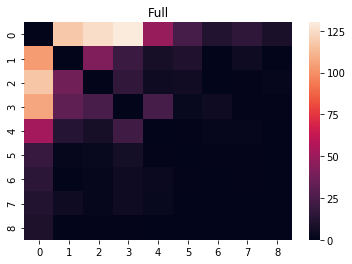

In [16]:
# Full
df_full = df.copy()
df_full["labelx"] = df_full["labelx"].map(cluster_dict)
df_full.sort_index(level=["Individual"],inplace=True)

df_full["labelxs"] = df_full["labelx"].shift(-1)
df_full.drop(21,level="Day",inplace=True)

counts = {i[0]:(len(i[1]) if i[0][0] != i[0][1] else 0) for i in df_full.groupby(by=["labelx","labelxs"])}

matrix = pd.DataFrame()

for x in labelx:
    matrix[str(x)] = pd.Series([counts.get((x,y), 0) for y in labelx], index=labelx)

sns.heatmap(matrix)
plt.title("Full")
plt.savefig("../../figures/transitions/full.pdf",bbox_inches="tight")

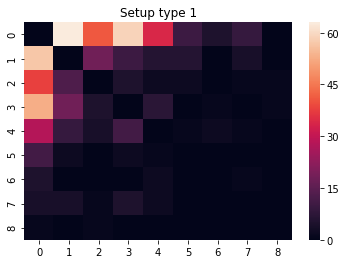

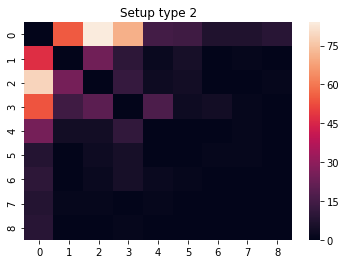

In [17]:
# Setup type
for setup in [1,2]:
    df_set = df.loc[(slice(None),slice(None),setup),:].copy()
    df_set["labelx"] = df_set["labelx"].map(cluster_dict)
    df_set.sort_index(level=["Individual"],inplace=True)

    df_set["labelxs"] = df_set["labelx"].shift(-1)
    df_set.drop(21,level="Day",inplace=True)

    counts = {i[0]:(len(i[1]) if i[0][0] != i[0][1] else 0) for i in df_set.groupby(by=["labelx","labelxs"])}

    matrix = pd.DataFrame()

    for x in labelx:
        matrix[str(x)] = pd.Series([counts.get((x,y), 0) for y in labelx], index=labelx)

    sns.heatmap(matrix)
    plt.title("Setup type %d"%setup)
    plt.savefig("../../figures/transitions/setup-type-%d.pdf"%setup,bbox_inches="tight")
    plt.show()

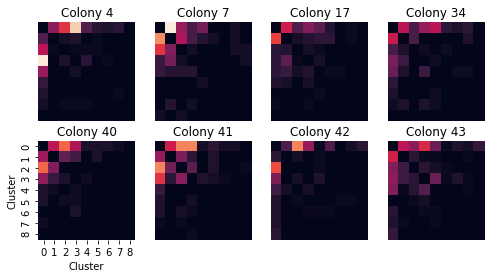

In [18]:
#columns
fig,axes=plt.subplots(2,4,figsize=(8,4))
for ax,col in zip(axes.flat,[4,7,17,34,40,41,42,43]):

    df_col = df.loc[col]
    n_ants = len(df_col.index.get_level_values("Individual").unique())
    
    df_col["labelx"] = df_col["labelx"].map(cluster_dict)
    df_col.sort_index(level=["Individual"],inplace=True)
    
    df_col["labelxs"] = df_col["labelx"].shift(-1)
    df_col.drop(21,level="Day",inplace=True)

    counts = {i[0]:(len(i[1]) if i[0][0] != i[0][1] else 0) for i in df_col.groupby(by=["labelx","labelxs"])}

    matrix = pd.DataFrame()
    for x in labelx:
        matrix[x] = pd.Series([counts.get((x,y), 0) for y in labelx], index=labelx)
    sns.heatmap(matrix/n_ants,ax=ax,vmin=0,vmax=1.75,cbar=False)
    if col == 40:
        ax.set(xlabel="Cluster",ylabel="Cluster")
    else:
        ax.axis('off')
    ax.set(title="Colony %d"%col)
    
plt.savefig("../../figures/transitions/colonies.pdf",bbox_inches="tight")
plt.show()